In [70]:
import numpy as np
import math 
import pprint
from marchMadnessBracket.utils import *
from marchMadnessBracket.Team import Team
from marchMadnessBracket.Bracket import Bracket,EvoBracket
from marchMadnessBracket.torch_bracket import TorchBracket
import pickle
from marchMadnessBracket.data.bracket_2021 import teams, human_picks
from IPython import display
import pylab as pl
from time import perf_counter
from scipy.signal import savgol_filter

In [71]:
with open('trained_bracket.pkl', 'rb') as f:
    mc_human = pickle.load(f)

In [72]:
realistic_game_logisitic_11p7 = lambda x: realistic_game_logisitic(x,width=11.7)
simulation_bracket = Bracket.from_array(teams,{"sim_method":realistic_game_logisitic})

In [73]:
evo_brackets = [EvoBracket.from_array(teams) for _ in range(50)]
for evo_bracket in evo_brackets:
    evo_bracket.random_flip(p_flip=1)
evo_brackets = np.array(evo_brackets)

In [74]:
simulation_bracket = Bracket.from_array(teams,{"sim_method":realistic_game_logisitic})

In [75]:
def human_round(n_humans,round_winners):
    return np.array([mc_human.score(round_winners) for _ in range(n_humans)])

In [76]:
def evo_round(evo_brackets,round_winners):
    return np.array([evo_bracket.score(round_winners) for evo_bracket in evo_brackets])

In [77]:
n_humans = 20

In [78]:
def print_time_delta(time=0):
    new_time = perf_counter()
    if time: print(new_time-time)
    return new_time

In [79]:
def one_round(evo_brackets):
    round_winners = simulation_bracket.round_winners()
    human_scores = human_round(n_humans,round_winners) 
    score_to_beat = np.max(human_scores)  
    evo_scores = evo_round(evo_brackets,round_winners) 
    would_win = evo_scores > score_to_beat  
    return would_win

In [80]:
def many_rounds(n_rounds,evo_brackets):
    round_results = [one_round(evo_brackets) for _ in range(n_rounds)]
    return np.sum(round_results,axis=0)

In [81]:
def select_winers_losers(evo_brackets,round_results):
    evo_results = list(zip(evo_brackets,round_results))
    evo_results = sorted(evo_results,key = lambda x: -(x[1]+.0001*np.mean(x[0].scores[-1]) ))
    evo_brackets,round_results = zip(*evo_results)
    n_brackets = len(evo_brackets)
    cut = int(n_brackets/(3))
    winners = evo_brackets[:-cut]
    losers = evo_brackets[-cut:]
    
    win_res = round_results[:-cut]
    loser_res = round_results[-cut:]    
    
    [winner.epoch_update(win_res,0) for winner, win_res in zip(winners,win_res)]
    [loser.epoch_update(lose_res,1) for loser, lose_res in zip(losers,loser_res)]
        
    return winners, losers

In [82]:
def random_teams(temp_list):
    len_list = len(temp_list)
    rand1,rand2 = np.random.randint(0,len_list-1,size=2)
    return temp_list[rand1],temp_list[rand2]

In [83]:
def combine_list(l1,l2):
    assert len(l1) == len(l2), "lists must be same length"
    length = len(l1)
    rand_arr = np.random.rand(length)
    combined_list = [l1_el if r>.5 else l2_el  for r,l1_el, l2_el in zip(rand_arr,l1,l2)]
    return np.array(combined_list)

In [84]:
def update_losers(loser_list, winner_list):
    for loser in loser_list:
        w1,w2 =  random_teams(winner_list)
        w1_arr, w2_arr = w1.win_loss_array, w2.win_loss_array
        wl_arr = combine_list(w1_arr, w2_arr)
        loser.win_loss_array = wl_arr
        loser.random_flip(p_flip=.03)

In [85]:
def one_epoch(evo_brackets):
    time = perf_counter()
    round_results = many_rounds(100,evo_brackets)
    winners, losers = select_winers_losers(evo_brackets,round_results)
    print("--------")
    update_losers(losers, winners)
    evo_brackets = np.concatenate((winners ,losers))
    
    return evo_brackets, round_results

In [86]:
from scipy.optimize import curve_fit

def logisitc(x,offset,scale,norm):
    return norm/(1+(2*2.7)**(-(x-offset)/scale))
results = []
chalks = []

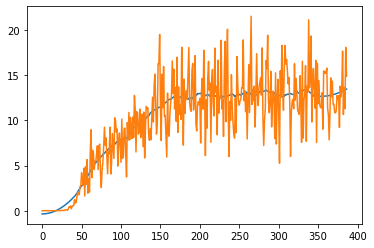

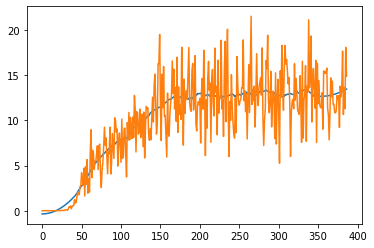

In [141]:
for i in range(100):
    evo_brackets, round_results = one_epoch(evo_brackets)
    avg_wins = np.mean(round_results)
    results.append(avg_wins)
    chalk = np.mean([ev.chalk[-1] for ev in evo_brackets])
    chalks.append(chalk)
    print("wins: {} chalks: {}".format(avg_wins,chalk))

    pl.clf()
    if len(results)> 71:
        yhat = savgol_filter(results, 85, 2)
        plt.plot(yhat, label=" Savitzky-Golay Filter")
    pl.plot(results)
    display.clear_output(wait=True)
    display.display(pl.gcf())

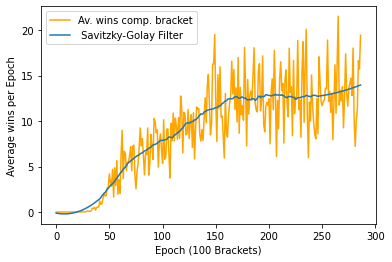

<Figure size 432x288 with 0 Axes>

In [140]:
import matplotlib.pyplot as plt
plt.plot(results, label = "Av. wins comp. bracket", color='orange')
x = np.array([i for i in range(len(results))])

yhat = savgol_filter(results, 81, 2)
plt.plot(yhat, label=" Savitzky-Golay Filter")
plt.ylabel("Average wins per Epoch")
plt.xlabel("Epoch (100 Brackets)")
plt.legend()
plt.savefig("output/trained_from_anti_chalk.png")
plt.show()

plt.clf()


In [117]:
evo_brackets = sorted(evo_brackets,key=lambda ev: -ev.wins[-1])

In [118]:
resets = evo_brackets[0].resets
wins = evo_brackets[0].wins

def surive_streak(resets, wins):
    counter = 0
    win_counter = 0
    for i,wins in zip(resets,wins):
        if i==1:
            counter=0
            win_counter = 0
        if i==0:
            counter+=1
            win_counter+= wins
    return counter, win_counter

In [119]:
team_ranking = [surive_streak(team.resets,team.wins) for team in evo_brackets]

In [133]:
for i,(r,w) in enumerate(sorted(team_ranking, key=lambda x: -x[1]/(x[0]+.1))):
    print(i, w/(r+.1),w/(r+.1)-w**.5/(r+.1)*2, r)

0 20.0 11.471971345775582 1
1 18.18181818181818 10.050661900000764 1
2 18.18181818181818 10.050661900000764 1
3 18.18181818181818 10.050661900000764 1
4 18.18181818181818 10.050661900000764 1
5 18.095238095238095 12.224367616220022 2
6 18.095238095238095 12.224367616220022 2
7 18.064516129032256 13.236571113840075 3
8 17.741935483870968 12.95729129864796 3
9 17.619047619047617 11.825940447335027 2
10 17.419354838709676 12.678406949451912 3
11 17.073170731707318 12.991902309589875 4
12 17.073170731707318 12.991902309589875 4
13 17.073170731707318 12.991902309589875 4
14 16.585365853658537 12.56282377988521 4
15 16.585365853658537 12.56282377988521 4
16 14.979253112033193 13.402489626556015 24
17 14.793388429752067 12.581968899130636 12
18 14.774774774774775 12.467342617141316 11
19 14.741035856573705 13.208335931340928 25
20 14.741035856573705 13.208335931340928 25
21 14.71264367816092 13.21104077070763 26
22 14.71264367816092 13.21104077070763 26
23 14.71264367816092 13.21104077070763 

In [134]:
rws = evo_brackets[16].round_winners()

In [135]:
chalk = evo_brackets[16].win_loss_array

In [136]:
index = 0
for r in rws:
    for game in r:
        print(game,chalk[index])
        index+=1

Gonzaga 0
Oklahoma 0
Creighton 0
Virginia 0
USC 0
Kansas 0
Oregon 0
Iowa 0
Michigan 0
LSU 0
Colorado 0
Florida St. 0
MSU/UCLA 1
Texas 0
Connecticut 0
Alabama 0
Baylor 0
Wisconsin 0
Villanova 0
Purdue 0
Texas Tech 0
Arkansas 0
Florida 0
Ohio St. 0
Illinois 0
Georgia Tech 1
Tennessee 0
Oklahoma St. 0
SDSU 0
West Virginia 0
Rutgers 0
Houston 0
Gonzaga 0
Virginia 1
Kansas 0
Iowa 0
Michigan 0
Florida St. 0
Texas 0
Alabama 0
Baylor 0
Villanova 0
Texas Tech 0
Ohio St. 0
Illinois 0
Tennessee 0
West Virginia 0
Houston 0
Gonzaga 0
Iowa 0
Michigan 0
Alabama 0
Baylor 0
Ohio St. 0
Illinois 0
Houston 0
Iowa 1
Michigan 0
Baylor 0
Houston 1
Iowa 0
Baylor 0
Baylor 0


In [137]:
rws

[['Gonzaga',
  'Oklahoma',
  'Creighton',
  'Virginia',
  'USC',
  'Kansas',
  'Oregon',
  'Iowa',
  'Michigan',
  'LSU',
  'Colorado',
  'Florida St.',
  'MSU/UCLA',
  'Texas',
  'Connecticut',
  'Alabama',
  'Baylor',
  'Wisconsin',
  'Villanova',
  'Purdue',
  'Texas Tech',
  'Arkansas',
  'Florida',
  'Ohio St.',
  'Illinois',
  'Georgia Tech',
  'Tennessee',
  'Oklahoma St.',
  'SDSU',
  'West Virginia',
  'Rutgers',
  'Houston'],
 ['Gonzaga',
  'Virginia',
  'Kansas',
  'Iowa',
  'Michigan',
  'Florida St.',
  'Texas',
  'Alabama',
  'Baylor',
  'Villanova',
  'Texas Tech',
  'Ohio St.',
  'Illinois',
  'Tennessee',
  'West Virginia',
  'Houston'],
 ['Gonzaga',
  'Iowa',
  'Michigan',
  'Alabama',
  'Baylor',
  'Ohio St.',
  'Illinois',
  'Houston'],
 ['Iowa', 'Michigan', 'Baylor', 'Houston'],
 ['Iowa', 'Baylor'],
 ['Baylor']]